Goal: Predict total number of citibike rides each day, based on variables such as year,month,day of week, temperature. etc.

Steps:
- Will do for one year to start, then extend
- Get total # rides grouped by day
- Get daily temperatures
- Separate into predictors/target
- Train/test split
- Fit linear regression, Ridge, Lasso models and evaluate performance.

In [1]:
# import libraries and connect to database
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
con = sqlite3.connect("data/citibike_database.db3")
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['lines.linewidth'] = 3

## Get total number of rides each day (target variable)

In [2]:
year = 2016
query = "SELECT yday,wkday,count(*) as N FROM rides WHERE year=? GROUP BY yday"
df = pd.read_sql_query(query,con,params=[year])
df.head()

,yday,wkday,N
0,1,4,11009
1,2,5,14587
2,3,6,15499
3,4,0,19593
4,5,1,18053


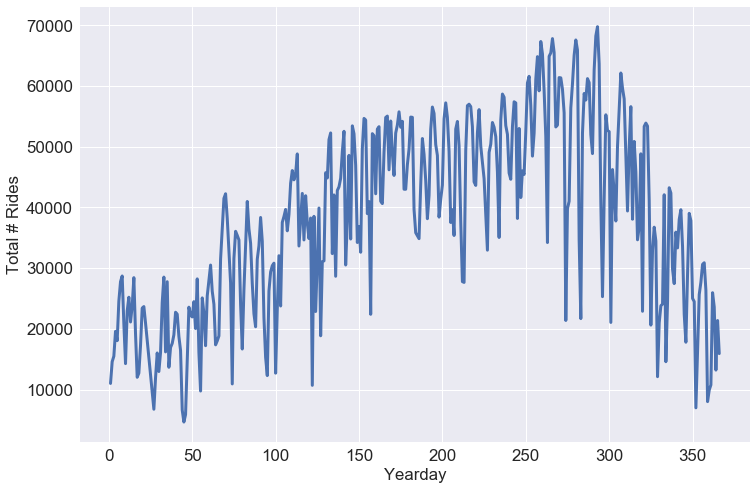

In [3]:
plt.figure(figsize=(12,8))
plt.plot(df.yday, df.N);
plt.xlabel('Yearday')
plt.ylabel('Total # Rides');

## get number of distinct stations each day (feature)

In [4]:
query = "SELECT yday,count(distinct start_station_id) as N_sta FROM rides WHERE year=? GROUP BY yday"
df_sta = pd.read_sql_query(query,con,params=[year])
df_sta.head()

,yday,N_sta
0,1,460
1,2,462
2,3,461
3,4,467
4,5,468


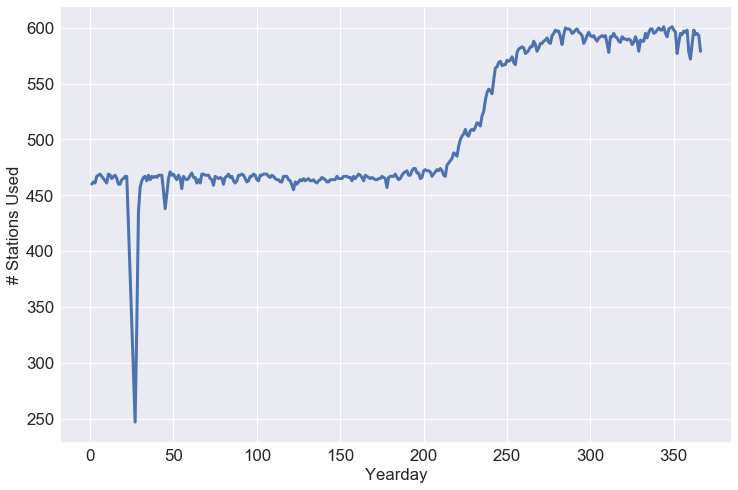

In [5]:
# Plot # stations vs yday (only counts tations that were used that day, so not necessarily
# all stations in service)
# NOTE spikes are likely days where not many rides taken
# should smooth these?
plt.figure(figsize=(12,8))
plt.plot(df_sta.yday, df_sta.N_sta);
plt.xlabel('Yearday')
plt.ylabel('# Stations Used');

## Get daily weather (features)

In [6]:
con2 = sqlite3.connect('data/nyc_weather.db3')
query2 = "SELECT yday,mean_temp as Tmean,precip_In,max_gust_mph,cloud_cover  FROM temps WHERE year=?"
df2 = pd.read_sql_query(query2, con2, params=[year])
df2.loc[df2.precip_In=='T'] = 0
df2.loc[:,'precip_In'] = df2.astype({'precip_In':'float64'})
df2.head()

,yday,Tmean,precip_In,max_gust_mph,cloud_cover
0,1,40,0.0,31.0,6
1,2,38,0.0,31.0,4
2,3,42,0.0,28.0,2
3,4,27,0.0,40.0,3
4,5,22,0.0,33.0,0


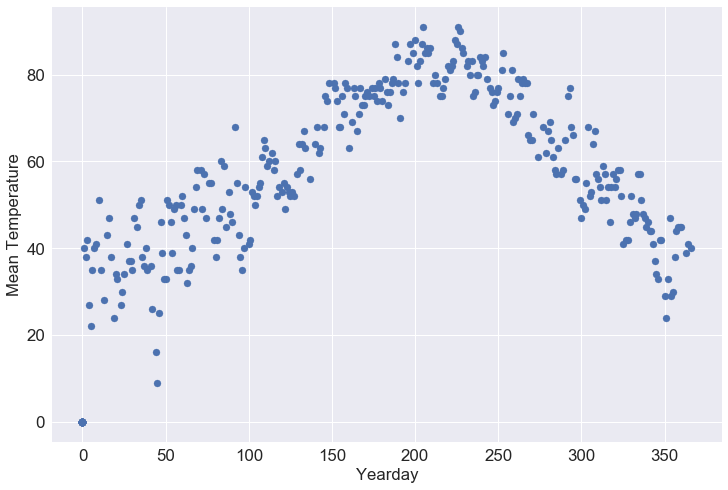

In [7]:
plt.figure(figsize=(12,8))
plt.scatter(df2.yday, df2.Tmean);
plt.xlabel('Yearday')
plt.ylabel('Mean Temperature');

## Join data frames

In [8]:
# join temps to rides data frame
df_comb = pd.merge(df,df2,left_on='yday',right_on='yday')
df_comb = pd.merge(df_comb, df_sta, left_on='yday',right_on='yday')
df_comb.head()

,yday,wkday,N,Tmean,precip_In,max_gust_mph,cloud_cover,N_sta
0,1,4,11009,40,0.0,31.0,6,460
1,2,5,14587,38,0.0,31.0,4,462
2,3,6,15499,42,0.0,28.0,2,461
3,4,0,19593,27,0.0,40.0,3,467
4,5,1,18053,22,0.0,33.0,0,468


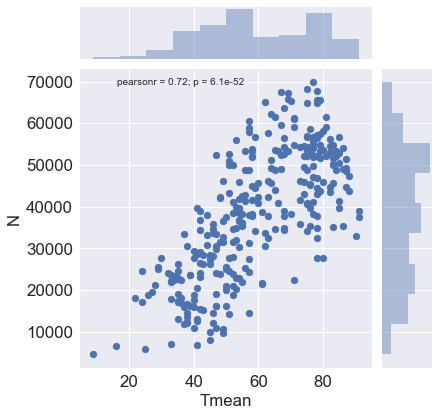

In [9]:
sns.jointplot(df_comb.Tmean,df_comb.N);

The daily # rides is positively correlated with daily temperature, but there is a lot of unexplained scatter.

## create dummy variables for wkday

In [10]:
# NOTE drop_first drops redundant column from dummy vars
df_comb = pd.get_dummies(data=df_comb, columns=['wkday'],drop_first=True)
df_comb.head()

,yday,N,Tmean,precip_In,max_gust_mph,cloud_cover,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6
0,1,11009,40,0.0,31.0,6,460,0,0,0,1,0,0
1,2,14587,38,0.0,31.0,4,462,0,0,0,0,1,0
2,3,15499,42,0.0,28.0,2,461,0,0,0,0,0,1
3,4,19593,27,0.0,40.0,3,467,0,0,0,0,0,0
4,5,18053,22,0.0,33.0,0,468,1,0,0,0,0,0


## split data into predictor/target arrays in prep for modelling

In [11]:
X = df_comb.drop(['yday','N'], axis=1)
X.head()

,Tmean,precip_In,max_gust_mph,cloud_cover,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6
0,40,0.0,31.0,6,460,0,0,0,1,0,0
1,38,0.0,31.0,4,462,0,0,0,0,1,0
2,42,0.0,28.0,2,461,0,0,0,0,0,1
3,27,0.0,40.0,3,467,0,0,0,0,0,0
4,22,0.0,33.0,0,468,1,0,0,0,0,0


In [12]:
y = df_comb['N']
y.head()

0    11009
1    14587
2    15499
3    19593
4    18053
Name: N, dtype: int64

## Split data into training/test sets

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.3, random_state=39)

## Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score

imp = Imputer(strategy='most_frequent')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test =imp.transform(X_test)
X_all = imp.transform(X)

reg = LinearRegression()
reg.fit(X_train,y_train)
preds = reg.predict(X_test)
np.mean(cross_val_score(reg,X_train,y_train))

0.83101793284857084

In [15]:
# score on training set
reg.score(X_train,y_train)

0.85825077756543589

In [16]:
# score on test set
reg.score(X_test,y_test)

0.78893151358987623

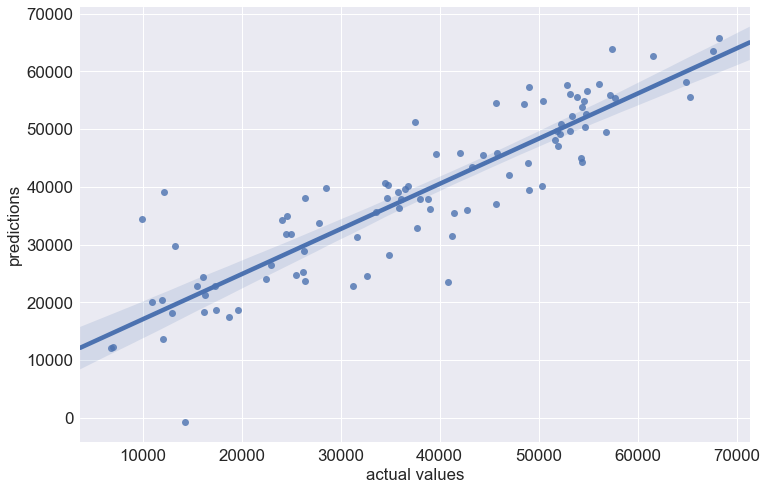

In [17]:
# plot predictions vs actual values
plt.figure(figsize=(12,8))
#plt.scatter(y_test,preds)
sns.regplot(y_test,preds)
plt.xlabel('actual values')
plt.ylabel('predictions');

In [18]:
# Examine coefficients
coefs = pd.DataFrame({'vars':X.columns,'coef':reg.coef_})
coefs.sort_values('coef',ascending=False)

,coef,vars
5,3847.028803,wkday_1
6,3495.595699,wkday_2
7,3487.345180,wkday_3
0,563.620606,Tmean
4,78.277613,N_sta
2,-230.088653,max_gust_mph
8,-762.361965,wkday_4
3,-1462.419970,cloud_cover
9,-6751.695744,wkday_5
10,-8085.355541,wkday_6


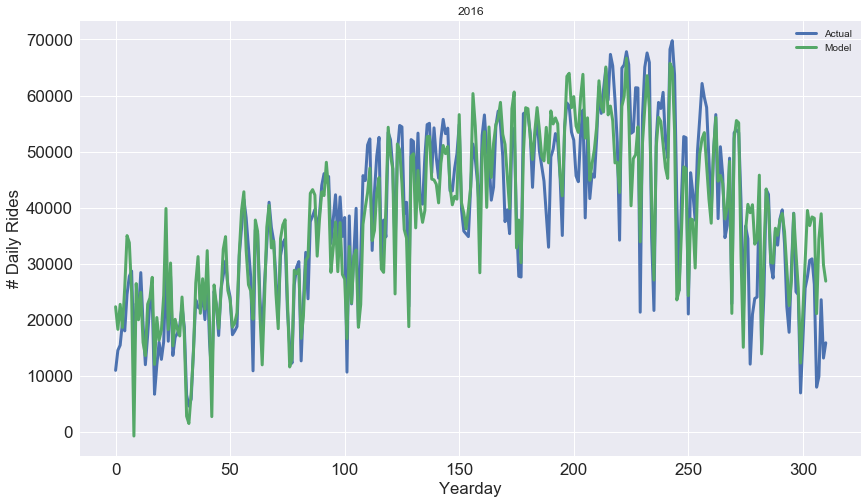

In [19]:
plt.figure(figsize=(14,8))
plt.plot(y,label='Actual')
plt.plot(reg.predict(X_all),label='Model')
plt.legend();
plt.xlabel('Yearday')
plt.ylabel('# Daily Rides')
plt.title(str(year));

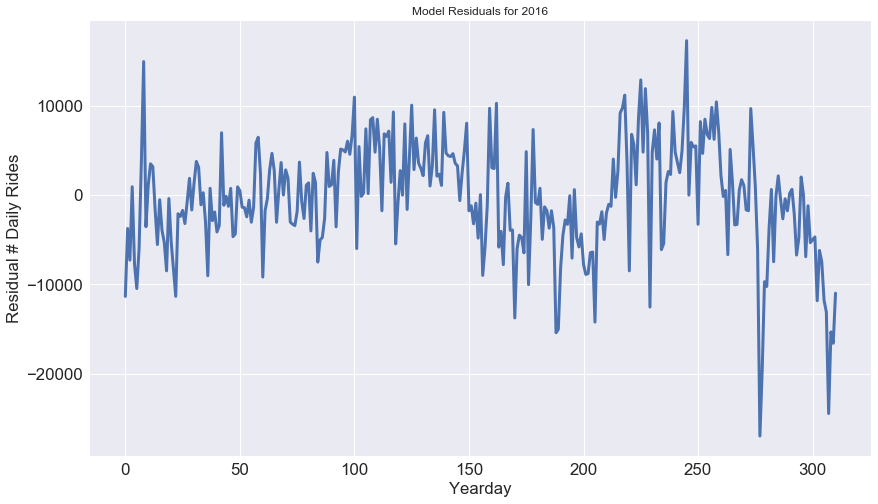

In [20]:
plt.figure(figsize=(14,8))
#plt.plot(y,label='Actual')
plt.plot(y-reg.predict(X_all))
#plt.legend();
plt.xlabel('Yearday')
plt.ylabel('Residual # Daily Rides')
plt.title('Model Residuals for ' + str(year));

### Look at dates of residuals to see if any are holidays etc:

In [21]:
X2 = df_comb.copy()
X2['resid'] = y - reg.predict(X_all)
X2.head(10)

,yday,N,Tmean,precip_In,max_gust_mph,cloud_cover,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,resid
0,1,11009,40,0.00,31.0,6,460,0,0,0,1,0,0,-11347.838379
1,2,14587,38,0.00,31.0,4,462,0,0,0,0,1,0,-3734.658551
2,3,15499,42,0.00,28.0,2,461,0,0,0,0,0,1,-7280.309464
3,4,19593,27,0.00,40.0,3,467,0,0,0,0,0,0,936.462215
4,5,18053,22,0.00,33.0,0,468,1,0,0,0,0,0,-7708.621646
5,6,24569,35,0.00,17.0,1,469,0,1,0,0,0,0,-10465.532510
6,7,27773,40,0.00,15.0,4,467,0,0,1,0,0,0,-5987.747195
7,8,28709,41,0.00,24.0,6,465,0,0,0,1,0,0,3786.532383
8,10,14275,51,1.42,40.0,7,461,0,0,0,0,0,1,14965.604080
9,11,22937,35,0.00,39.0,1,469,0,0,0,0,0,0,-3539.986453


In [22]:
X2.sort_values('resid').head(10)

,yday,N,Tmean,precip_In,max_gust_mph,cloud_cover,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,resid
277,329,12122,46,0.02,18.0,8,579,0,0,1,0,0,0,-26987.486133
307,360,9924,45,0.00,29.0,1,572,0,0,0,0,0,1,-24467.317607
278,330,20980,52,0.01,12.0,8,589,0,0,0,1,0,0,-19554.876409
309,364,13207,41,0.48,32.0,7,595,0,0,1,0,0,0,-16594.979618
188,226,38912,91,0.00,25.0,3,504,0,0,0,0,1,0,-15412.162306
308,363,23601,39,0.00,27.0,5,594,0,1,0,0,0,0,-15322.150115
189,227,32961,90,0.01,37.0,4,503,0,0,0,0,0,1,-15034.054747
205,245,38187,77,0.34,21.0,7,569,0,0,1,0,0,0,-14221.999080
170,205,37523,91,0.00,32.0,2,467,0,0,0,0,1,0,-13756.690038
306,359,8014,45,0.52,27.0,7,578,0,0,0,0,1,0,-13102.881999


In [23]:
# get dates for these
query ='SELECT distinct year,month,day,yday FROM rides WHERE year=?'
df_dates = pd.read_sql_query(query,con,params=[year])
df_dates.head()


,year,month,day,yday
0,2016,1,1,1
1,2016,1,2,2
2,2016,1,3,3
3,2016,1,4,4
4,2016,1,5,5


In [24]:
X2=X2.merge(df_dates,left_on='yday',right_on='yday')
X2.shape

(311, 17)

In [25]:
X2.head()

,yday,N,Tmean,precip_In,max_gust_mph,cloud_cover,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,resid,year,month,day
0,1,11009,40,0.0,31.0,6,460,0,0,0,1,0,0,-11347.838379,2016,1,1
1,2,14587,38,0.0,31.0,4,462,0,0,0,0,1,0,-3734.658551,2016,1,2
2,3,15499,42,0.0,28.0,2,461,0,0,0,0,0,1,-7280.309464,2016,1,3
3,4,19593,27,0.0,40.0,3,467,0,0,0,0,0,0,936.462215,2016,1,4
4,5,18053,22,0.0,33.0,0,468,1,0,0,0,0,0,-7708.621646,2016,1,5


In [26]:
query = "SELECT * FROM holidays WHERE public=1 AND year=?"
df_holi = pd.read_sql_query(query,con,params=[year])
df_holi

,date,name,observed,public,yday,year
0,2016-01-01 00:00:00,New Year's Day,2016-01-01 00:00:00,1,1,2016
1,2016-01-18 00:00:00,"Martin Luther King, Jr. Day",2016-01-18 00:00:00,1,18,2016
2,2016-02-15 00:00:00,George Washington's Birthday,2016-02-15 00:00:00,1,46,2016
3,2016-05-30 00:00:00,Memorial Day,2016-05-30 00:00:00,1,151,2016
4,2016-07-04 00:00:00,Independence Day,2016-07-04 00:00:00,1,186,2016
5,2016-09-05 00:00:00,Labor Day,2016-09-05 00:00:00,1,249,2016
6,2016-10-10 00:00:00,Columbus Day,2016-10-10 00:00:00,1,284,2016
7,2016-11-11 00:00:00,Veterans Day,2016-11-11 00:00:00,1,316,2016
8,2016-11-24 00:00:00,Thanksgiving Day,2016-11-24 00:00:00,1,329,2016
9,2016-12-25 00:00:00,Christmas Day,2016-12-26 00:00:00,1,361,2016


In [27]:
X2 = X2.merge(df_holi,left_on='yday',right_on='yday',how='left')
X2.public.fillna(0,inplace=True)
X2.sort_values('resid').head(10)


,yday,N,Tmean,precip_In,max_gust_mph,cloud_cover,N_sta,wkday_1,wkday_2,wkday_3,...,wkday_6,resid,year_x,month,day,date,name,observed,public,year_y
277,329,12122,46,0.02,18.0,8,579,0,0,1,...,0,-26987.486133,2016,11,24,2016-11-24 00:00:00,Thanksgiving Day,2016-11-24 00:00:00,1.0,2016.0
307,360,9924,45,0.00,29.0,1,572,0,0,0,...,1,-24467.317607,2016,12,25,NaN,NaN,NaN,0.0,NaN
278,330,20980,52,0.01,12.0,8,589,0,0,0,...,0,-19554.876409,2016,11,25,NaN,NaN,NaN,0.0,NaN
309,364,13207,41,0.48,32.0,7,595,0,0,1,...,0,-16594.979618,2016,12,29,NaN,NaN,NaN,0.0,NaN
188,226,38912,91,0.00,25.0,3,504,0,0,0,...,0,-15412.162306,2016,8,13,NaN,NaN,NaN,0.0,NaN
308,363,23601,39,0.00,27.0,5,594,0,1,0,...,0,-15322.150115,2016,12,28,NaN,NaN,NaN,0.0,NaN
189,227,32961,90,0.01,37.0,4,503,0,0,0,...,1,-15034.054747,2016,8,14,NaN,NaN,NaN,0.0,NaN
205,245,38187,77,0.34,21.0,7,569,0,0,1,...,0,-14221.999080,2016,9,1,NaN,NaN,NaN,0.0,NaN
170,205,37523,91,0.00,32.0,2,467,0,0,0,...,0,-13756.690038,2016,7,23,NaN,NaN,NaN,0.0,NaN
306,359,8014,45,0.52,27.0,7,578,0,0,0,...,0,-13102.881999,2016,12,24,NaN,NaN,NaN,0.0,NaN


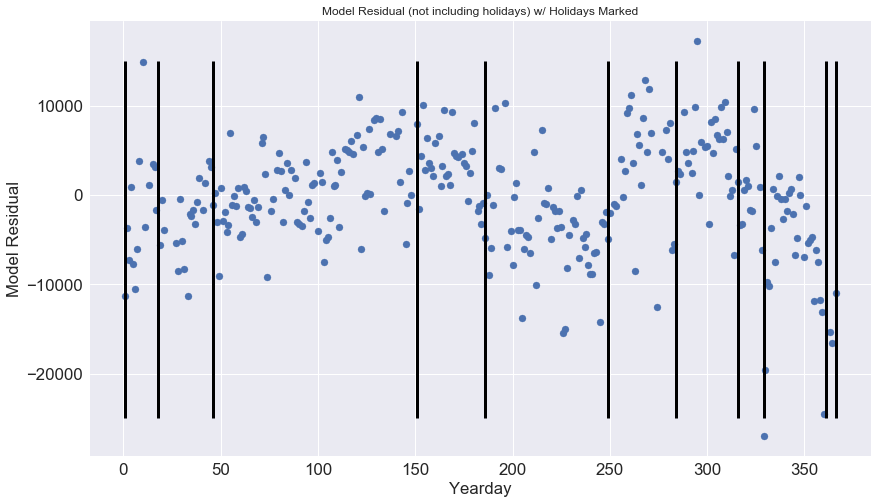

In [28]:
plt.figure(figsize=(14,8))
plt.scatter(X2.yday,X2.resid)
plt.vlines(df_holi.yday,-25000,15000)
plt.xlabel('Yearday')
plt.ylabel('Model Residual')
plt.title('Model Residual (not including holidays) w/ Holidays Marked')

## Add holiday to features

In [29]:
X3 = X2.copy()
X3.drop(['month','day','date','year_x','name','observed','year_y','resid','N','yday'],axis=1,inplace=True)
#X2.drop('resid',inplace=True,axis=1)
#X2.drop('yday',axis=1,inplace=True)
X3.head()

,Tmean,precip_In,max_gust_mph,cloud_cover,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,public
0,40,0.0,31.0,6,460,0,0,0,1,0,0,1.0
1,38,0.0,31.0,4,462,0,0,0,0,1,0,0.0
2,42,0.0,28.0,2,461,0,0,0,0,0,1,0.0
3,27,0.0,40.0,3,467,0,0,0,0,0,0,0.0
4,22,0.0,33.0,0,468,1,0,0,0,0,0,0.0


In [30]:
# split into training/testing again, using X2 this time
X_train, X_test, y_train, y_test = train_test_split(X3,y,test_size= 0.3, random_state=39)
imp=Imputer()
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)
reg2 = LinearRegression()
reg2.fit(X_train,y_train)
np.mean(cross_val_score(reg2,X_train,y_train))
#reg2.score(X_test,y_test)

0.83265654057842475

In [31]:
coefs = pd.DataFrame({'vars':X3.columns,'coef':reg2.coef_})
coefs.sort_values('coef')

,coef,vars
1,-13111.092147,precip_In
10,-8748.770469,wkday_6
9,-7179.362276,wkday_5
11,-5862.252846,public
3,-1449.916051,cloud_cover
8,-1100.201573,wkday_4
2,-210.680455,max_gust_mph
4,78.963757,N_sta
0,562.659787,Tmean
7,2806.664104,wkday_3


### adding holidays doesn't seem to improve the model. It looks like a lot of the big residueals occur a day or two before/after holidays; maybe try making a 'near holiday' variable?
- example: 2 days before/after Thanksgiving
- last days of December (people likely take long weekend before New years
- Xmas in 2016 was 'observed' on the 26th. Need to modify holiday df to include both actual and observed dates for holidays?

## To do:
- Try adding interactions between the variables?
- Try ridge or lasso regression?
- Do for all 3 years
- remove outliers in # stations?

# NOTE below old, not updated yet...

## Try adding interactions between the variables

In [32]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True)
#poly.fit_transform(X)
#poly.get_feature_names()
#inter.shape
poly_df = pd.DataFrame.from_records(poly.fit_transform(X),columns=poly.get_feature_names())
poly_df.head()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
X_int = pd.concat([X,poly_df],axis=1)
X_int.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_int,y,test_size= 0.3, random_state=39)
reg_int = LinearRegression()
reg_int.fit(X_train,y_train)
preds = reg_int.predict(X_test)
cross_val_score(reg_int,X_train,y_train)
reg_int.score(X_test,y_test)
#X_test.shape

## Next i'll try some linear regression models w/ regularization, which shoud reduce overfitting.

### Ridge Regression
Ridge regression can shrink the coefficients close to, but not exactly zero.

In [ ]:
from sklearn.linear_model import Ridge
rid = Ridge()
rid.fit(X_train,y_train)
preds = rid.predict(X_test)
rid.score(X_train,y_train)

In [ ]:
np.mean(cross_val_score(rid,X_train,y_train))

In [ ]:
rid.score(X_test,y_test)

In [ ]:
coefs = pd.DataFrame({'vars':X.columns,'coef':rid.coef_})
coefs.sort_values('coef')

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(y_test,preds)
plt.xlabel('actual value')
plt.ylabel('prediction');

In [ ]:
cross_val_score(rid,X_train,y_train)

In [ ]:
# look at residuals
plt.figure(figsize=(12,8))
preds = rid.predict(X)
resids = y-preds
plt.scatter(y,resids);
plt.xlabel('actual value')
plt.ylabel('residuals');
# looks like error/residual is corellated with y value
# model overestimates low values, and overestimates larger values??

Ridge model has parameter *alpha* we can tune, which controls the strength of the regularization; use GridSearchCV to try to optimize:

In [ ]:
from sklearn.model_selection import GridSearchCV
rid = Ridge()
params = {'alpha':[0.1, 0.5, 1,2,5, 100]}
cv_rid = GridSearchCV(rid,params)
cv_rid.fit(X_train,y_train)
cv_rid.best_params_

In [ ]:
cv_rid.best_score_

In [ ]:
# score on test set
cv_rid.score(X_test,y_test)

### Lasso
In Lasso, some of the coefficients can actually be set to zero.

In [ ]:
# try lasso
from sklearn.linear_model import Lasso
las = Lasso(max_iter=4000)
params = {'alpha':[0.1, 0.5, 1,2,10, 100]}
cv_las = GridSearchCV(las,params)
cv_las.fit(X_train,y_train)
cv_las.best_params_
#cv_las.best_score_

In [ ]:
cv_las.score(X_test,y_test)

In [ ]:
plt.figure(figsize=(12,8))
#plt.scatter(y_test,cv_las.predict(X_test));
sns.regplot(y_test,cv_las.predict(X_test));
plt.xlabel('actual value')
plt.ylabel('prediction')

In [ ]:
plt.figure(figsize=(10,8))
#plt.scatter(y_test,y_test-cv_las.predict(X_test));
sns.regplot(y_test,y_test-cv_las.predict(X_test));
plt.xlabel('actual value')
plt.ylabel('residual')

In [ ]:
# compare test-set scores of all3
print('LinReg test score: ' + str(reg.score(X_test,y_test)))
print('ridge test score: ' + str(cv_rid.score(X_test,y_test)))
print('Lasso test score: ' + str(cv_las.score(X_test,y_test)))


In this case, Ridge and Lasso don't give much of an imporvement over simple linear regression. All 3 models get a R^2 score of about 0.78-0.79 on the test data.